# Logistic regression in practice - evaluation metrics - threshold tuning

This hands-on workshop shows:
* how to do logistic regression in practice using the sci-kit learn library
* several evaluation metrics, like auroc and f-score
* how to optimize the threshold

Explanation about precision, recall and F-score by Andrew Ng:
* [Error Metrics For Skewed Classes](https://www.youtube.com/watch?v=wGw6R8AbcuI&list=PLLssT5z_DsK-h9vYZkQkYNWcItqhlRJLN&index=67) (12 min).
* [Trading Off Precision And Recall](https://www.youtube.com/watch?v=W5meQnGACGo&list=PLLssT5z_DsK-h9vYZkQkYNWcItqhlRJLN&index=68) (14 min).

This workshop is heavily based on [A Gentle Introduction to Threshold-Moving for Imbalanced Classification](https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/), [Understanding AUC - ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5) and [Classification: ROC Curve and AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

## Converting Probabilities to Class Labels

Many machine learning algorithms are capable of predicting a probability of class membership. This is useful generally as it provides a measure of the certainty or uncertainty of a prediction.

Some classification tasks require a crisp class label prediction. This means that even though a probability of class membership is predicted, it must be converted into a crisp class label.

The decision for converting a predicted probability into a class label is governed by a hyperparameter referred to as the *decision threshold*. The default value for the threshold is 0.5. For example, on a binary classification problem with class labels 0 and 1, then values less than the threshold of 0.5 are assigned to class 0 and values greater than or equal to 0.5 are assigned to class 1.
* Prediction < 0.5 => Class 0
* Prediction >= 0.5 => Class 1

The problem is that the default threshold may not represent an optimal interpretation of the predicted probabilities. This might be the case if the class distribution is severely skewed, for example in the case of cancer screening, 95.5% will turn out healthy, wherease only 0.5% of the people will be diagnosed cancer. Another reason why the default threshold of 0.5 might not be optimal is if the cost of one type of misclassification is more important than another type of misclassification. As such, there is often the need to change the default decision threshold. 

## Optimal Threshold for ROC Curve

Let's assume that the positive class (y=1) denotes that the person is diagnosed with cancer. Let's assume that the data set is heavily skewed anf that the positive class is the minority class.

**ROC curve**. The false-positive rate is plotted on the x-axis and the true-positive rate is plotted on the y-axis and the plot is referred to as the Receiver Operating Characteristic curve, or ROC curve. A diagonal line on the plot from the bottom-left to top-right indicates the "curve" for a *no-skill classifier* (predicts the majority class in all cases), and a point in the top left of the plot indicates a model with perfect skill.

The ROC curve is a useful diagnostic tool for understanding the trade-off in the true-positive rate and false-positive rate for different thresholds. The area under the ROC Curve, so-called ROC AUC, provides a single number to summarize the performance of the model in terms of its ROC Curve with a value between 0.5 (no-skill) and 1.0 (perfect skill). If crisp class labels are required from the model, then an optimal threshold is required. This would be a threshold on the curve that is closest to the top-left of the plot.

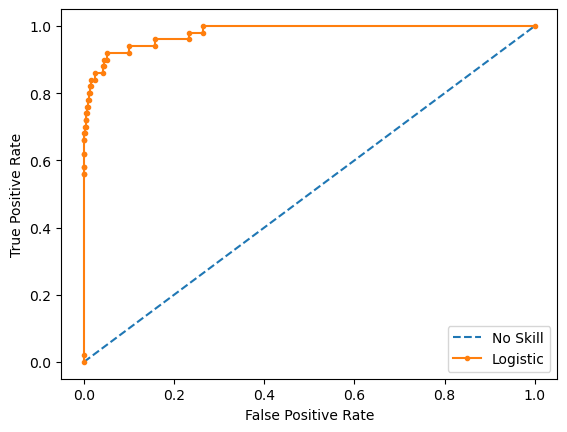

In [1]:
# roc curve for logistic regression model
from numpy import sqrt
from numpy import argmax
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.99], flip_y=0, 
    random_state=4)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)

# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)

# predict probabilities on the test set
yhat = model.predict_proba(testX)
# yhat contains two columns, 1st colum: probability for negative outcome, 2nd column: probability for positive outcome
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Running the example fits a logistic regression model on the training dataset then evaluates it using a range of thresholds on the test set, creating the ROC Curve. We can see that there are a number of points or thresholds close to the top-left of the plot. Which is the threshold that is optimal?

There are many ways we could locate the threshold with the optimal balance between false positive and true positive rates. Firstly, the true positive rate is called the Sensitivity. The inverse of the false-positive rate is called the Specificity.
* Sensitivity = TruePositive / (TruePositive + FalseNegative)
* Specificity = TrueNegative / (FalsePositive + TrueNegative)

Where:
* Sensitivity = True Positive Rate
* Specificity = 1 – False Positive Rate

The Geometric Mean or G-Mean is a metric for imbalanced classification that, if optimized, will seek a balance between the sensitivity and the specificity.

G-Mean = sqrt(Sensitivity * Specificity)

Given that we have already calculated the Sensitivity (TPR) and the complement to the Specificity when we calculated the ROC Curve, we can calculate the G-Mean for each threshold directly.

Best Threshold=0.015790, G-Mean=0.934


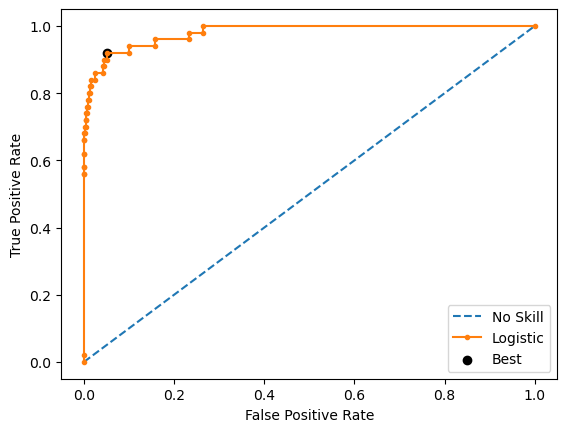

In [2]:
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

We can see that the point for the optimal threshold is a large black dot and it appears to be closest to the top-left of the plot.

## Optimal Threshold for Precision-Recall Curve

Unlike the ROC Curve, a precision-recall curve focuses on the performance of a classifier on the positive (minority class) only.

* Precision = TruePositive / (TruePositive + FalsePositive)
* Recall = TruePositive / (TruePositive + FalseNegative)

Precision describes how good a model is at predicting the positive class. Recall is the same as sensitivity.

A precision-recall curve is calculated by creating crisp class labels for probability predictions across a set of thresholds and calculating the precision and recall for each threshold. A line plot is created for the thresholds in ascending order with recall on the x-axis and precision on the y-axis.

A no-skill model is represented by a horizontal line with a precision that is the ratio of positive examples in the dataset (e.g. TP / (TP + TN)), or 0.01 on our synthetic dataset. A perfect skill classifier has full precision and recall with a dot in the top-right corner.

We can use the same model and dataset from the previous section and evaluate the probability predictions for a logistic regression model using a precision-recall curve. The precision_recall_curve() function can be used to calculate the curve, returning the precision and recall scores for each threshold as well as the thresholds used.

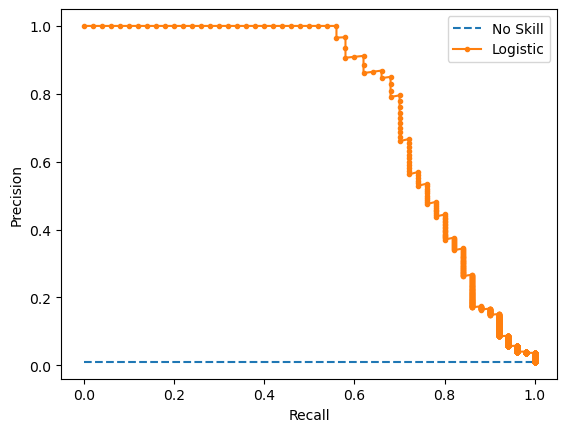

In [3]:
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(testy, yhat)

# plot the pr-curve for the model
no_skill = len(testy[testy==1]) / len(testy)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

If we required crisp class labels from this model, which threshold would achieve the best result?

If we are interested in a threshold that results in the best balance of precision and recall, then this is the same as optimizing the F-score that summarizes the harmonic mean of both measures.

F-score = (2 * Precision * Recall) / (Precision + Recall)

The following code converts the precision and recall to the F-score.

Best Threshold=0.257034, F-Score=0.756


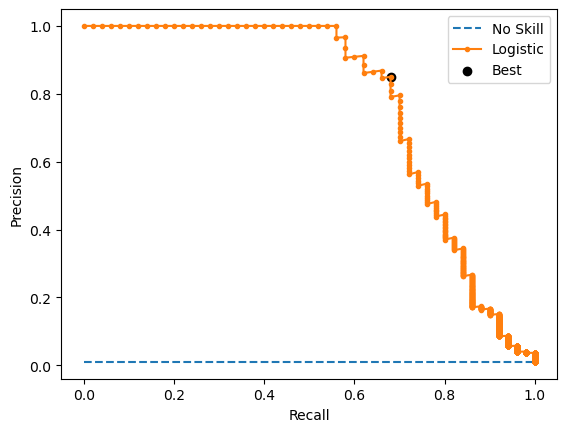

In [4]:
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

# plot the pr-curve for the model
no_skill = len(testy[testy==1]) / len(testy)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

This threshold associated with the highest F-score, could then be used when making probability predictions in the future that must be converted from probabilities to crisp class labels.

## Optimal Threshold Tuning

Sometimes, we simply have a model and we wish to know the best threshold directly. In this case, we can define a set of thresholds and then evaluate predicted probabilities under each in order to find and select the optimal threshold.

First, we fit a logistic regression model on our synthetic classification problem, then predict class labels and evaluate them using the F-Measure, which is the harmonic mean of precision and recall. This will use the default threshold of 0.5 when interpreting the probabilities predicted by the logistic regression model.

In [5]:
# logistic regression for imbalanced classification
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict labels
yhat = model.predict(testX)
# evaluate the model
score = f1_score(testy, yhat)
print('F-Score: %.5f' % score)

F-Score: 0.70130


Running the example, we can see that the model achieved an F-Measure of about 0.70 on the test dataset.

Next, we can then define a set of thresholds to evaluate the probabilities. In this case, we will test all thresholds between 0.0 and 1.0 with a step size of 0.001, that is, we will test 0.0, 0.001, 0.002, 0.003, and so on to 0.999.

Next, we need a way of using a single threshold to interpret the predicted probabilities.

This can be achieved by mapping all values equal to or greater than the threshold to 1 and all values less than the threshold to 0. We will define a to_labels() function to do this that will take the probabilities and threshold as an argument and return an array of integers in {0, 1}.

We can then call this function for each threshold and evaluate the resulting labels using the f1_score().

We can do this in a single line, as follows:

We now have an array of scores that evaluate each threshold in our array of thresholds.

All we need to do now is locate the array index that has the largest score (best F-Measure) and we will have the optimal threshold and its evaluation.

In [6]:
# search thresholds for imbalanced classification
from numpy import arange
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
yhat = model.predict_proba(testX)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(testy, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.252, F-Score=0.75556


Running the example reports the optimal threshold as 0.252 (compared to the default of 0.5) that achieves an F-Measure of about 0.75 (compared to 0.70).

## Discussion

ROC or F-score?
* https://stackoverflow.com/questions/44172162/f1-score-vs-roc-auc
* https://stats.stackexchange.com/questions/210700/how-to-choose-between-roc-auc-and-f1-score